In [1]:
#import scaper
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import Thesis_models
import Thesis_models_nonTime

sr = 24000




In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Not in order of the MultiLabelBinarizer, disregard the order
DESED_classes = ['Alarm_bell_ringing', 'Blender', 'Cat', 'Dishes', 'Dog', 'Electric_shaver_toothbrush', 'Frying', 'Running_water', 'Speech', 'Vacuum_cleaner']

In [3]:

scene_path = '/Volumes/Expansion/DESED/Dataset_Output_Folder/audio/train/synthetic21_train/soundscapes/'
#uni_name = 'soundscape_unimodal' 
scene_size = sr*10

# Create dict for labels

#labels_dict = {'non-vehicle':0, 'cars':1, 'motorcycles':2, 'tanks':3, 'trucks':4}
#labels_names = ['no_event','cars', 'motorcycles', 'tanks', 'trucks']

def audio_input_shaper(path, available_ids):
    audio_input = (np.zeros(1,10,4096,1))
    for i in available_ids:
        audio, _ = librosa.load(path + str(i)+'.wav', sr=sr, mono=True)
        x = np.pad(audio, (2861,2898))
        x = np.reshape(x, (6,10,4096,1))
        audio_input = np.concatenate((audio_input, x), axis=0)

    audio_input = audio_input[1,:]

    return audio_input

n_soundscapes = 1000

#features = np.zeros((1,10,4096,1))
#labels = np.zeros((1, 10, 1))

features = []
labels = []

for scns in range(n_soundscapes):
    scene, _ = librosa.load(scene_path + str(scns) + '.wav', sr=sr, mono=True)
    
    x1 = np.pad(scene, (2861,2898))
    x = np.reshape(x1, (6,10,4096,1))
    features.append(x)
    #features = np.concatenate((features, x), axis=0)

    headers = ['onset', 'offset', 'label']
    txt = pd.read_csv(scene_path + str(scns) + '.txt', sep='\t',  names=headers, index_col=False)

    # split scene in chunks for labels
    chunk_size = 4096
    time_step = 64
    step_size = chunk_size//time_step
    
    # Iterating through the whole sound scene capturing labels
    for i in range(0, x1.size, step_size):
        labels_temp = []
        for b, row in txt.iterrows():
            onset = int(row['onset'])*sr
            offset = int(row['offset'])*sr
            if onset < (i+step_size) and offset > (i):
                labels_temp.append(row['label'])
            else:
                pass    
    
        for label in labels_temp:
            if label in DESED_classes:

                pass
            else:
                labels_temp = ['None']
        labels.append(labels_temp)
        

features_out = np.concatenate(features, axis=0)
print('Labels before MultiLabelBinarizer one row example: {}'.format(labels[0]))
print('Labels before MultiLabelBinarizer second row example: {}'.format(labels[1]))
one_hot = MultiLabelBinarizer()
labels = one_hot.fit_transform(labels) 
label_names = one_hot.classes_
print('Labels shape before reshape is {}'.format(labels.shape))
print('Labels one row example: {}'.format(labels[0]))
print('Labels one row example: {}'.format(labels[1]))
labels = np.reshape(labels, ((n_soundscapes*6),10, step_size, len(label_names)))

print(features_out.shape, labels.shape)
print(label_names)

Labels before MultiLabelBinarizer one row example: ['None']
Labels before MultiLabelBinarizer second row example: ['None']
Labels shape before reshape is (3840000, 11)
Labels one row example: [0 0 0 0 0 0 0 1 0 0 0]
Labels one row example: [0 0 0 0 0 0 0 1 0 0 0]
(6000, 10, 4096, 1) (6000, 10, 64, 11)
['Alarm_bell_ringing' 'Blender' 'Cat' 'Dishes' 'Dog'
 'Electric_shaver_toothbrush' 'Frying' 'None' 'Running_water' 'Speech'
 'Vacuum_cleaner']


In [15]:
print('Labels one row example: {}'.format(labels[3210,6,1,:]))

Labels one row example: [0 0 0 0 0 0 1 0 0 0 0]


In [4]:
tf.keras.backend.clear_session()

In [ ]:
CRNN_RAe2e = Thesis_models.CRNN(len(label_names), 128, [5, 2, 2], [64, 64], [32], 10, 4096, 128, 64, sr=sr, melspec=False)
CRNN_RAe2e.summary()

In [5]:
LSTM_RAe2e = Thesis_models.LSTM_backend_2(10, 4096, 128, 64, n_of_classes=len(label_names), frame_level_classification=False, output_dim=64, melspec=False, sr=sr)
LSTM_RAe2e.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 4096, 1)]     0         
                                                                 
 conv (TimeDistributed)      (None, 10, 4096, 128)     8320      
                                                                 
 conv_activation (TimeDistri  (None, 10, 4096, 128)    0         
 buted)                                                          
                                                                 
 conv_smoothing (TimeDistrib  (None, 10, 4096, 128)    16512     
 uted)                                                           
                                                                 
 conv_smoothing_activation (  (None, 10, 4096, 128)    0         
 TimeDistributed)                                                
                                                              

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(CRNN_RAe2e, 'CRNN_RAe2e.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=396)

In [ ]:
LSTM_Mel = Thesis_models.LSTM_backend(10, 4096, 128, 64, n_of_classes=len(label_names), frame_level_classification=False, output_dim=64, melspec=True, sr=sr)
LSTM_Mel.summary()

In [6]:


LSTM_RAe2e = Thesis_models.LSTM_backend(10, 4096, 128, 64, n_of_classes=len(label_names), frame_level_classification=False, output_dim=64, melspec=False, sr=sr)
LSTM_RAe2e.summary()


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-01-18 11:18:48.585070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-18 11:18:48.585951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 4096, 1)]     0         
                                                                 
 conv (TimeDistributed)      (None, 10, 4096, 128)     8320      
                                                                 
 conv_activation (TimeDistri  (None, 10, 4096, 128)    0         
 buted)                                                          
                                                                 
 conv_smoothing (TimeDistrib  (None, 10, 4096, 128)    16512     
 uted)                                                           
                                                                 
 conv_smoothing_activation (  (None, 10, 4096, 128)    0         
 TimeDistributed)                                                
                                                              

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(LSTM_Mel, 'LSTM_Mel.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=396)

In [6]:
from sklearn.model_selection import train_test_split 
# forgot the random seed here so the +10 epoch evals are no good...
feat_train, feat_test, lab_train, lab_test = train_test_split(features_out, labels, test_size=0.2, random_state=42)

print(feat_train.shape)

(4800, 10, 4096, 1)


In [7]:
#  Run this cell if using RNN layers which are not timedistributed (LSTM_backend_2)

lab_train_ = np.reshape(lab_train, (lab_train.shape[0],(lab_train.shape[1]*lab_train.shape[2]),len(label_names)))
print(lab_train_.shape)

(4800, 640, 11)


2023-01-19 00:27:08.720977: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3840/3840 [==============================] - 9295s 2s/step - loss: 0.1917 - accuracy: 0.5366 - val_loss: 0.1848 - val_accuracy: 0.5480


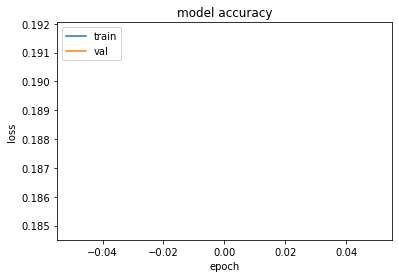

In [8]:
# For LSTM_backend_2 set batch size to 1. For all others batchsize = 10
callback_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

history = LSTM_RAe2e.fit(
    feat_train,
    lab_train_,
    validation_split=0.2,
    #class_weight= {0: 1.0, 1: 1.0, 2: 0.5, 3: 0.5, 4: 1.0},
    batch_size=1,
    shuffle=True,
    epochs=1,
    callbacks = [callback_stop]
    
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [11]:
tf.executing_eagerly()


True

In [9]:
lab_test_ = np.reshape(lab_test, (lab_test.shape[0],(lab_test.shape[1]*lab_test.shape[2]),len(label_names)))
print(lab_test_.shape)
#feat_test_ = np.reshape(feat_test, (120,4096,1))
#lab_test_ = np.reshape(lab_test, (120,64,5))

LSTM_RAe2e.evaluate(feat_test, lab_test_)

(1200, 640, 11)
38/38 [==============================] - 391s 10s/step - loss: 0.1895 - accuracy: 0.5547


[0.18951570987701416, 0.5546810030937195]

* CRNN_Rafe 1 epoch 100 soundscapes (approx 12 minutes): loss: 0.2611 - accuracy: 0.3840
* CRNN_RAe2e 1 ep 100sc (fixed LR, rnns:[64,64]): [0.2245444357395172, 0.4411458373069763]
* LSTM_Rafe 1 epoch 100 soundscapes (approx 9 min): loss: 0.2174 - accuracy: 0.5179
* LSTM RAe2e 1 ep 100s (fixed LR no sched) : loss: 0.2451 - accuracy: 0.4411
* LSTM_mel 10 epochs 100 soundscapes (approx 7s pr epoch): loss: 0.2120 - accuracy: 0.4411 (Didn't seem to learn, loss decreased but accuracy remained the same)
* CRNN_Mel 10 epochs 100 soundscapes (approx 2:30 min pr epoch): loss: 0.2177 - accuracy: 0.4411 (Didn't seem to learn. Guess the log mels are blank...)
* CRNN_Mel 2 eps 100s (mels flipped 90 degrees): loss: 0.2165 - accuracy: 0.4411

NO TIME DISTRIBUTION TESTS:
* LSTM_RAe2e 10 epochs (10 soundscapes)(1 minute each) shuffle=True: [0.1243598461151123, 0.4678385555744171]
* LSTM_RAe2e 10 epochs (10 soundscapes) shuffle=False: [0.15079300105571747, 0.4694010317325592] (Did not "learn", loss and accuracy almost identical all epochs)

TIME DIST ONLY ON FRONTEND:
* LSTM_RAe2e 1 epoch 100 soundscapes (15 min): loss: 0.2130 - accuracy: 0.4411
* LSTM RAe2e 1 ep 1000 soundscapes (2 hours+):  loss: 0.1895 - accuracy: 0.5547

In [10]:
path = '/Users/arvidfalch/Documents/Thesis/Idfrontend2/RAe2e/Models/'
model_description = '1epoch_LSTM_RAe2e_notime_rnns_1000sc'
tf.keras.models.save_model(LSTM_RAe2e, path + model_description)

2023-01-19 07:55:31.541654: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/arvidfalch/Documents/Thesis/Idfrontend2/RAe2e/Models/1epoch_LSTM_RAe2e_notime_rnns_1000sc/assets


In [ ]:
#model = tf.keras.models.load_model('1d5epochs2classesscraper_new_metrics_binaryc_loss')
import librosa
#path = '/Users/arvidfalch/repos/scaper_test/soundscapes/soundscape_unimodal7.wav'
# stab
#path = '/Users/arvidfalch/Desktop/BLLTImpt_Bullets_Impact_Body_Thump_Soundly_SND6360.wav'
# tanks
#path = '/Users/arvidfalch/Desktop/NoCatID_War_Heavy_Trucks_Passing_By_Close_Multiple_Multiple_Heavy_Trucks_Pass_0001_by_JoniHeinonen_Id_161880_JoniHeinonen_None.wav'
#path = '/Users/arvidfalch/repos/sq/machine-learning-data/benchmark/dvc-machine-learning-vehicle-data/2021-12-14_Rena_Panzerwagen_hx128ip-00053/2021-12-14T11.09.34UTC_to_2021-12-14T11.10.32UTC_3c2be265/gain_39dB/label_type_track_0.wav'

# Cars
#path = '/Users/arvidfalch/repos/sq/machine-learning-data/benchmark/dvc-machine-learning-vehicle-data/2021-05-10 car record session us/Sqbundles/2021-05-10T20.23.13UTC_Unknown_US_HX128IP-00014_sounds of things.vehicle.motor vehicle (road).car_from_0.00s_to_3.85s/gain_39dB/label_type_track_0.wav'
#path = '/Users/arvidfalch/repos/sq/machine-learning-data/benchmark/dvc-machine-learning-vehicle-data/2022-07-01_Gaustad_Oslo/2022-07-01T08.54.09UTC_to_2022-07-01T08.54.17UTC_5b95032d/gain_39dB/label_type_track_0.wav'
# Deep bass
#path = '/Users/arvidfalch/Desktop/DSGNRmbl_Designed_Rumble_Bass_Hit_Soundly_SND42461.wav'
#path = '/Users/arvidfalch/Desktop/NoCatID_Sweep02_by_833_45_Id_9370_833_45_None.wav'
#path = '/Users/arvidfalch/Desktop/NoCatID_Long_Cinematic_Sweep_by_stair_Id_156862_stair_None.wav'
#path = '/Users/arvidfalch/Desktop/stockhausen_synth_wav.wav'
#path = '/Users/arvidfalch/repos/Vehicles/Air/Drones/Aircraft_Radio_Controlled_Drone_Start_Engines_Slow_Not_Lifting_Off_Then_Stop_Syma_X5SW_SND29303.wav'
#path = '/Users/arvidfalch/repos/arvidfalch/Dataset2/2019-03-20_rangetest/2019-03-20T13.34.02UTC_Vestby_R128-1-00002_Rangetest - preflight_from_0.13s_to_38.97s/gain_39dB/label_type_track_2.wav'
# drone
#path = '/Users/arvidfalch/repos/scaper_test/foreground/drone/Drone112.wav'
#path = '/Users/arvidfalch/repos/scaper_test/foreground/drone/Drone145.wav'
# Chatting cafe
path = '/Users/arvidfalch/repos/Vehicles/Non-Vehicle/chatting cafes/Crowds_Walla_Hotel_Seminar_Room_Interior_Royal_Savoy_Lausanne_200_People_Talking_Business_Hours_SND63966.wav'
# Drone upclose flying away
#path = '/Users/arvidfalch/repos/scaper_test/foreground/drone/Drone150.wav'
# Drone flying off far away
#path = '/Users/arvidfalch/repos/scaper_test/foreground/drone/Drone154.wav'
# drone
#path = '/Users/arvidfalch/repos/scaper_test/soundscapes/soundscape_unimodal4.wav'
# short drone
#path = '/Users/arvidfalch/repos/scaper_test/soundscapes/soundscape_unimodal7.wav'
# Very high frequencies
#path = '/Users/arvidfalch/Desktop/NoCatID_Test_Tones_by_acclivity_Id_20680_acclivity_None.wav'
# Freq Sweep
#path = '/Users/arvidfalch/Desktop/NoCatID_Sine_Sweep_20_Hz_To_20_Khz_10_Seconds_by_reaktorplayer_Id_94224_reaktorplayer_None.wav'
# Hydro
#path = '/Users/arvidfalch/Desktop/point_az_0.5_el_-5.5.wav'

signal, _ = librosa.load(path, sr = sr, mono=True)
if signal.size < sr*10:
  signal = np.pad(signal, (0, sr*10-signal.size+1))

signal = signal[0:240001]
x1 = np.pad(signal, (2861,2898))

test = np.reshape(x1, (6,10,4096,1))
layer_outputs = [layer.output for layer in model.layers[:]]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(test)
  
layer_names = []
  
for layer in model.layers[:]:
  layer_names.append(layer.name)
print(layer_names)
print(len(layer_names))
print(layer_names[5])
cont = activations[5]

cont_ = np.array([])
print(cont.shape)
for q in range(cont.shape[0]):
  for w in range(cont.shape[1]):
    cont_ = np.append(cont_, cont[q,w,:])
new_shape = int(cont.shape[0]*cont.shape[1]*cont.shape[2])
cont_ = cont_.reshape((new_shape, 128))
print(cont_.shape)
cont_ = cont_.transpose([1,0])

y = signal
y_pred = model.predict(test)

yy = tf.squeeze(y)
yy_pred = tf.squeeze(y_pred)

import librosa.display
x = signal
hop_length = 256
fig, ax = plt.subplots(figsize= (16,14), nrows=2, ncols=1, sharex=False)


D = librosa.amplitude_to_db(np.abs(librosa.stft(x, hop_length=hop_length)),

                            ref=np.max)

librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,

                         x_axis='time', ax=ax[0])


ax[0] = plt.imshow(cont_, cmap ='viridis', interpolation='nearest', aspect='auto') 

ax[1].set(title='Log-frequency power spectrogram (upper) vs latent space learned representation')

ax[1].label_outer()

In [ ]:
last_layer_test = np.array([activations[-1]])
mean_array = np.round(np.mean(last_layer_test,axis=-2),2)
print(mean_array)


In [ ]:
(1, 6, 10, 6)
last_layer_array = np.array([activations[-1]])
mean_array = np.round(np.mean(last_layer_array,axis=-2),2)



plt.figure(figsize=(16,4))
plt.plot(np.abs(x1), alpha=0.2)
plt.plot(np.repeat(np.ndarray.flatten(mean_array[:,:,:,0]),64*64))
plt.plot(np.repeat(np.ndarray.flatten(mean_array[:,:,:,1]),64*64))
plt.plot(np.repeat(np.ndarray.flatten(mean_array[:,:,:,2]),64*64))
plt.plot(np.repeat(np.ndarray.flatten(mean_array[:,:,:,3]),64*64))
plt.plot(np.repeat(np.ndarray.flatten(mean_array[:,:,:,4]),64*64))

plt.legend(['audio', 'non_ground','cars', 'motorcycles', 'tanks', 'trucks'], loc='upper right')

plt.axhline(0.5, c = 'black')

plt.title('Prediction on audio file, mean of predictions (sigmoid 0-1) over 4096 samples windows')
plt.show()

In [ ]:
import soundfile as sf
sf.write('chatter_from_bench.wav', x1, samplerate=24000)